In [17]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import sklearn
import sklearn.pipeline
import sklearn.neural_network
from sklearn import preprocessing

import calc_bal_acc

Contents of train_x.csv: arr of shape (2102, 784)
Contents of valid_x.csv: arr of shape (600, 784)


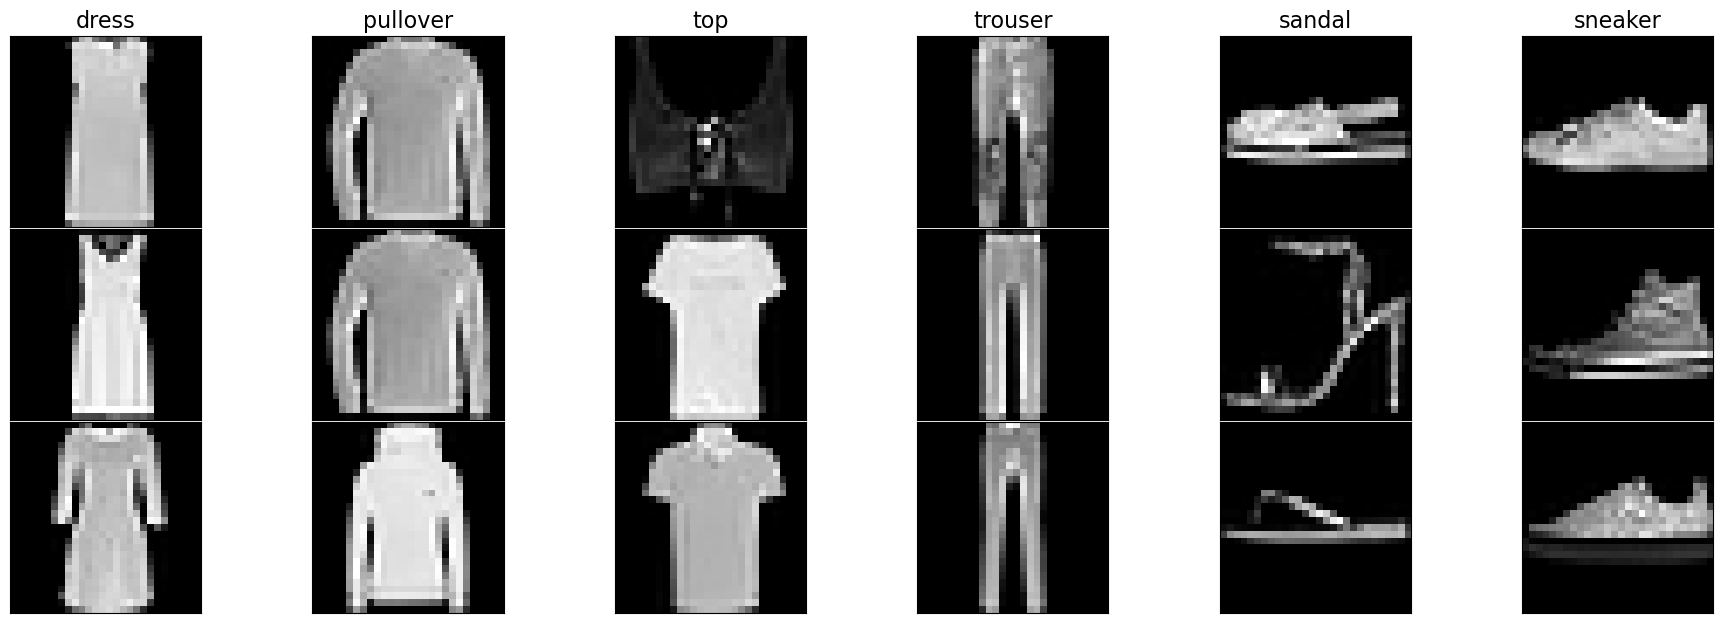

NameError: name 'datadir' is not defined

In [18]:
data_dir = os.path.abspath("data_fashion/")

# Load data
train_x = pd.read_csv(os.path.join(data_dir, "x_train.csv")).to_numpy()
train_y_df = pd.read_csv(os.path.join(data_dir, "y_train.csv"))

valid_x = pd.read_csv(os.path.join(data_dir, "x_valid.csv")).to_numpy()
valid_y_df = pd.read_csv(os.path.join(data_dir, "y_valid.csv"))

test_x = pd.read_csv(os.path.join(data_dir, "x_test.csv")).to_numpy()

# Print shapes
for label, arr in [('train', train_x), ('valid', valid_x)]:
    print("Contents of %s_x.csv: arr of shape %s" % (
        label, str(arr.shape)))

# Display via a figure a few examples of each image class

prng = np.random.RandomState(0)
N = 3 # num examples of each class to show
fig, axgrid = plt.subplots(N, 6, figsize=(6*3, N*2.5))

for ll, label in enumerate(['dress', 'pullover', 'top', 'trouser', 'sandal', 'sneaker']):
    match_df = valid_y_df.query("class_name == '%s'" % label)
    match_ids_N = prng.choice(match_df.index, size=N)        
    for ii, row_id in enumerate(match_ids_N):
        ax = axgrid[ii, ll]
        x_SS = valid_x[row_id].reshape((28,28))
        ax.imshow(x_SS, vmin=0, vmax=255, cmap='gray')
        ax.set_xticks([]); ax.set_yticks([]);
        if ii == 0:
            ax.set_title(label, fontsize=16)
plt.subplots_adjust(left=0.01, right=0.99, wspace=.2, hspace=.01)
#plt.tight_layout();
plt.show();


y_df_test = pd.read_csv(os.path.join(datadir, "y_valid.csv"))

In [19]:
pd.value_counts(np.array(train_y_df.loc[:,"class_name"]))

sandal      800
sneaker     800
dress       400
pullover    100
top           1
trouser       1
dtype: int64

In [20]:
pd.value_counts(np.array(valid_y_df.loc[:,"class_name"]))

dress       100
trouser     100
sandal      100
top         100
pullover    100
sneaker     100
dtype: int64

In [21]:
y_train = train_y_df.loc[:,"class_uid"]
y_valid = valid_y_df.values[:,1].copy()



y_valid_df = valid_y_df.loc[:,"class_uid"]
y_valid_arr = valid_y_df.loc[:,"class_uid"].to_numpy()
y_train_arr = train_y_df.loc[:,"class_uid"].to_numpy()
#print(type(y_train))
#print(y_train.shape)
#print(type(y_valid_df))
#print(y_valid_df.shape)


for n, values in enumerate(train_y_df['class_uid']):
    if values == 0:
        top = train_x[n]
        #print(n)
    if values == 1:
        trouser = train_x[n]
        #print(n)
tops = np.tile(top, (739, 1))
trousers = np.tile(trouser, (739, 1))

y_top = y_train.loc[np.repeat(1, 739)].reset_index(drop=True)
y_trouser = y_train.loc[np.repeat(11, 739)].reset_index(drop=True)




y_comb = np.hstack((y_train, y_top, y_trouser))
x_comb = np.concatenate((train_x, tops, trousers), axis=0)

print(x_comb.shape)
print(y_comb[3579])
print(train_x.shape)
print(y_train.shape)

(3580, 784)
1
(2102, 784)
(2102,)


In [22]:
def save_text(y_hat, file_name):
    names = ['top', 'trouser','pullover', 'dress','fifth','sandal','sixth','sneaker']
    

    # Load the dataset of interest
    datadir = os.path.abspath('data_fashion')
    x_NF = np.loadtxt(
        os.path.join(datadir, 'x_valid.csv'),
        delimiter=',',
        skiprows=1)
    N = x_NF.shape[0]

    # Create random predictions (just for fun)
    prng = np.random.RandomState(100)
    predictions = []
    for n in range(len(y_hat)):
        result = names[int(y_hat[n])]
        predictions.append(result)

    
    # Save the predictions in the leaderboard format
    np.savetxt(file_name, predictions, delimiter='\n', fmt='%s')

def pretty_print(y_valid, yhat):
    datadir = os.path.abspath('data_fashion')
    # Load true labels
    y_df = pd.read_csv(os.path.join(datadir, y_valid))
    #print(y_df)
    ytrue_N = y_df['class_name'].values
    # Load predictions
    try:
        yhat_N = np.loadtxt(yhat, dtype=str)
    except IOError:
        raise ValueError("Did you run save_rand_predictions.py first??")
    assert ytrue_N.shape == yhat_N.shape
    #print("Loaded true and predicted labels")
    disp_df = pd.DataFrame(np.hstack([yhat_N[:,np.newaxis], ytrue_N[:,np.newaxis]]),
        columns=['yhat', 'ytrue'])
    #print(disp_df)
    #print(ytrue_N)
    bal_acc = sklearn.metrics.balanced_accuracy_score(ytrue_N, yhat_N)
    #accuracy = sklearn.metrics.accuracy_score(ytrue_N, yhat_N)
    
    print("Balanced Accuracy: %.3f" % bal_acc)
    print("")
    #print("Accuracy: %.3f" % accuracy)
    #print("remember, balanced accuracy for a random guess should be (in expectation) 1/C = 1/6 = %.3f" % (1/6.))

In [23]:
valid_indicators_L = np.hstack([
    -1 * np.ones(y_train_arr.size), # -1 means never include this example in any test split
    0  * np.ones(y_valid_arr.size), #  0 means include in the first test split (we count starting at 0 in python)
    ])

my_splitter = sklearn.model_selection.PredefinedSplit(valid_indicators_L)



In [115]:
import time
start = time.time()

new_mlp = sklearn.pipeline.Pipeline([
    ('max_abs_scaler', preprocessing.MinMaxScaler()),
    ('my_classifier', sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(256,),
                                                           activation='relu',
                                                           solver='adam',
                                                           learning_rate_init=0.01,
                                                           random_state=5,
                                                           max_iter = 300,
                                                           alpha=0.0001,
                                                           early_stopping=True
                                                          )
    )
])

my_parameter_grid_by_name_embed = dict()
#my_parameter_grid_by_name_embed['my_classifier__learning_rate_init'] = np.logspace(-5, 1, 7)
my_parameter_grid_by_name_embed['my_classifier__alpha'] = np.logspace(-5, 1, 7)
#my_parameter_grid_by_name_embed['my_classifier__hidden_layer_sizes'] = [(256,), (224,),(448,)]
#my_parameter_grid_by_name_embed['my_classifier__max_iter'] = [100,200,250,300]
#['my_classifier__solver'] = ['sgd', 'adam','lbfgs']
#my_parameter_grid_by_name_embed['my_classifier__activation'] = ['relu', 'logistic','identity']
#my_parameter_grid_by_name_embed['my_classifier__random_state'] = np.random.randint(low=0, high=50, size=(50,))

grid_searcher_embed = sklearn.model_selection.GridSearchCV(
    new_mlp,
    my_parameter_grid_by_name_embed,
    scoring='balanced_accuracy',
    cv=5,
    return_train_score=True,
    n_jobs=-1,
    verbose=3,
    refit=False
)

#grid_searcher_embed.fit(train_x, y_train)
grid_searcher_embed.fit(x_comb, y_comb)
#y_hat = grid_searcher_embed.predict(valid_x)

for param_name in sorted(my_parameter_grid_by_name_embed.keys()):
    print("%s: %r" % (param_name, grid_searcher_embed.best_params_[param_name]))

end = time.time()
print(end - start)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
my_classifier__alpha: 1e-05
26.25293779373169


In [74]:
new_best_mlp = sklearn.pipeline.Pipeline([
    ('max_abs_scaler', preprocessing.MinMaxScaler()),
    ('my_classifier', sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(256,),
                                                           activation='relu',
                                                           solver='adam',
                                                           random_state=5,
                                                           max_iter = 300,
                                                           learning_rate_init=0.001,
                                                           alpha=0.00001,
                                                           early_stopping=True,
                                                           warm_start=True
                                                           #learning_rate = 'adaptive'
                                                          )
    )
])

#new_best_mlp.fit(train_x, y_train)
new_best_mlp.fit(x_comb, y_comb)
best_y_hat_valid = new_best_mlp.predict(valid_x)
best_y_hat_test = new_best_mlp.predict(test_x)

save_text(best_y_hat_valid, 'yhat_valid.txt')
save_text(best_y_hat_test, 'yhat_test.txt')
pretty_print('y_valid.csv','yhat_valid.txt')

Balanced Accuracy: 0.840



(600,) (600,)


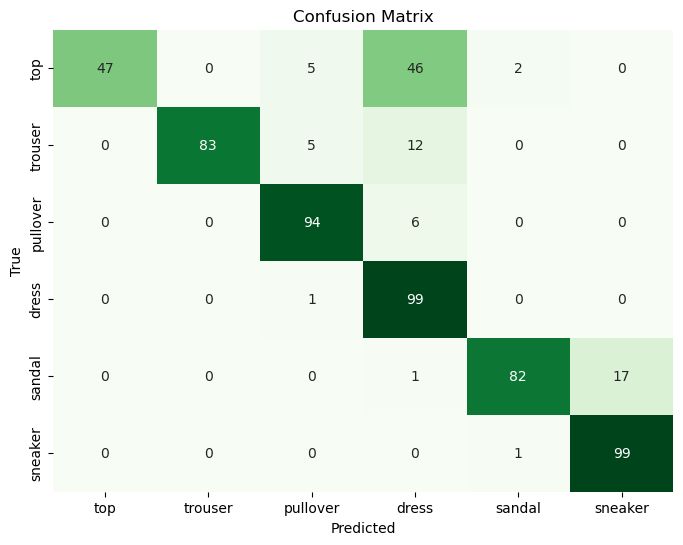

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

print(y_valid.shape, best_y_hat_valid.shape)

conf_matrix = confusion_matrix(list(y_valid), list(best_y_hat_valid))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['top', 'trouser', 'pullover', 'dress', 'sandal', 'sneaker'],
            yticklabels=['top', 'trouser', 'pullover', 'dress', 'sandal', 'sneaker'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



In [71]:
bal_acc_arr = []
add_arr = []
for add in np.arange(99, 999, 10):
    for n, values in enumerate(train_y_df['class_uid']):
        if values == 0:
            top = train_x[n]
            #print(n)
        if values == 1:
            trouser = train_x[n]
            #print(n)
    tops = np.tile(top, (add, 1))
    trousers = np.tile(trouser, (add, 1))
    
    y_top = y_train.loc[np.repeat(1, add)].reset_index(drop=True)
    y_trouser = y_train.loc[np.repeat(11, add)].reset_index(drop=True)


    

    y_comb_test = np.hstack((y_train, y_top, y_trouser))
    x_comb_test = np.concatenate((train_x, tops, trousers), axis=0)
    
    new_best_mlp = sklearn.pipeline.Pipeline([
        ('max_abs_scaler', preprocessing.MinMaxScaler()),
        ('my_classifier', sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(256,),
                                                               activation='relu',
                                                               solver='adam',
                                                               random_state=5,
                                                               max_iter = 300,
                                                               learning_rate_init=0.001,
                                                               alpha=0.00001,
                                                               early_stopping=True,
                                                               warm_start=True
                                                               #learning_rate = 'adaptive'
                                                              )
        )
    ])
    
    new_best_mlp.fit(x_comb_test, y_comb_test)
    #print("Number of duplicates: " + str(add))
    #new_best_mlp.fit(x_comb, y_comb)
    best_y_hat_valid = new_best_mlp.predict(valid_x)
    #best_y_hat_test = new_best_mlp.predict(test_x)
    #print("Current alpha is: " + str(i))
    

    ytrue_N = y_df_test['class_uid'].values
    #print(ytrue_N)
    bal_acc_test = sklearn.metrics.balanced_accuracy_score(ytrue_N, best_y_hat_valid)
    bal_acc_arr.append(bal_acc_test)
    add_arr.append(add)
    
    save_text(best_y_hat_valid, 'yhat_valid.txt')
    #pretty_print('y_valid.csv','yhat_valid.txt')


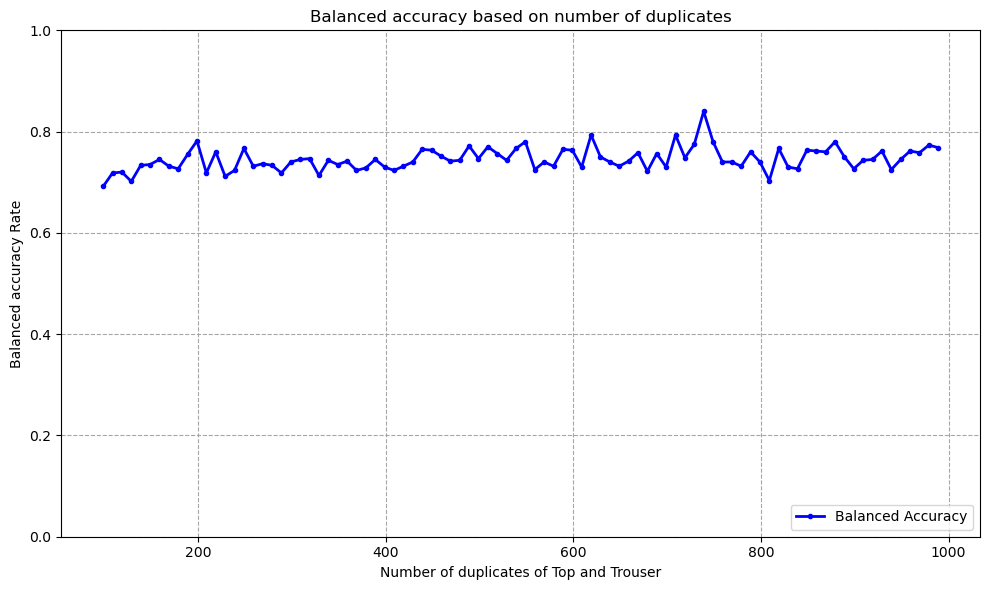

In [76]:
# Plotting
plt.figure(figsize=(10, 6))

# Training and validation mean scores
plt.plot(add_arr, bal_acc_arr, '.-', color='blue', lw=2, label='Balanced Accuracy')



plt.title("Balanced accuracy based on number of duplicates")
plt.xlabel('Number of duplicates of Top and Trouser')
plt.ylabel('Balanced accuracy Rate')
plt.legend(loc='lower right')
plt.ylim([0, 1])  # Assuming accuracy rate, range between 0 and 1
plt.grid(True, which="both", ls="--", c='0.65')
plt.tight_layout()
plt.show()

In [24]:
prob2_y_comb = np.hstack((y_train, y_valid))
prob2_x_comb = np.concatenate((train_x, valid_x), axis=0)

prob2_y_comb=prob2_y_comb.astype('int')

#print(prob2_y_comb[2701])
#print(prob2_x_comb[2701])

print(prob2_x_comb.shape)
print(prob2_y_comb.shape)

(2702, 784)
(2702,)


In [108]:
new_best_mlp = sklearn.pipeline.Pipeline([
    ('max_abs_scaler', preprocessing.MinMaxScaler()),
    ('my_classifier', sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(256,),
                                                           activation='relu',
                                                           solver='adam',
                                                           random_state=5,
                                                           max_iter = 300,
                                                           learning_rate_init=0.001,
                                                           alpha=0.00001,
                                                           early_stopping=True,
                                                           warm_start=True
                                                           #learning_rate = 'adaptive'
                                                          )
    )
])

#new_best_mlp.fit(train_x, y_train)

new_best_mlp.fit(prob2_x_comb, prob2_y_comb)
best_y_hat_valid = new_best_mlp.predict(valid_x)
best_y_hat_test = new_best_mlp.predict(test_x)

save_text(best_y_hat_valid, 'yhat_valid.txt')
save_text(best_y_hat_test, 'yhat_test.txt')
pretty_print('y_valid.csv','yhat_valid.txt')

Balanced Accuracy: 0.977



In [40]:
import time
start = time.time()

prob2_new_mlp = sklearn.pipeline.Pipeline([
    ('max_abs_scaler', preprocessing.MinMaxScaler()),
    ('my_classifier', sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(256,),
                                                           activation='relu',
                                                           solver='adam',
                                                           learning_rate_init=0.01,
                                                           random_state=5,
                                                           max_iter = 300,
                                                           alpha=0.00001,
                                                           early_stopping=True
                                                          )
    )
])

prob2_my_parameter_grid_by_name_embed = dict()
#prob2_my_parameter_grid_by_name_embed['my_classifier__learning_rate_init'] = np.logspace(-5, 1, 7)
prob2_my_parameter_grid_by_name_embed['my_classifier__alpha'] = np.logspace(-5, 1, 7)
#prob2_my_parameter_grid_by_name_embed['my_classifier__hidden_layer_sizes'] = [(256,), (224,),(448,)]
#prob2_my_parameter_grid_by_name_embed['my_classifier__max_iter'] = [100,200,250,300]
#['my_classifier__solver'] = ['sgd', 'adam','lbfgs']
#prob2_my_parameter_grid_by_name_embed['my_classifier__activation'] = ['relu', 'logistic','identity']
#prob2_my_parameter_grid_by_name_embed['my_classifier__random_state'] = np.random.randint(low=0, high=50, size=(50,))

prob2_grid_searcher_embed = sklearn.model_selection.GridSearchCV(
    prob2_new_mlp,
    prob2_my_parameter_grid_by_name_embed,
    scoring='balanced_accuracy',
    cv=5,
    return_train_score=True,
    #n_jobs=-1,
    verbose=3,
    refit=False
)

prob2_grid_searcher_embed.fit(train_x, y_train)
#prob2_grid_searcher_embed.fit(x_comb, y_comb)


gsearch_results_df_2 = pd.DataFrame(prob2_grid_searcher_embed.cv_results_).copy()
param_keys = ['param_my_classifier__alpha']
print(gsearch_results_df_2.round(3))
# Rearrange row order so it is easy to skim
gsearch_results_df_2.sort_values(param_keys, inplace=True)
var_2 = gsearch_results_df_2[param_keys + ['mean_test_score', 'rank_test_score']]
print(var_2)

for param_name in sorted(prob2_my_parameter_grid_by_name_embed.keys()):
    print("%s: %r" % (param_name, prob2_grid_searcher_embed.best_params_[param_name]))

end = time.time()
print(end - start)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


C:\Users\arman\.conda\envs\cs135_env\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV 1/5] END my_classifier__alpha=1e-05;, score=(train=0.998, test=0.765) total time=   3.0s
[CV 2/5] END my_classifier__alpha=1e-05;, score=(train=0.981, test=0.772) total time=   1.7s
[CV 3/5] END my_classifier__alpha=1e-05;, score=(train=0.993, test=0.936) total time=   2.5s
[CV 4/5] END my_classifier__alpha=1e-05;, score=(train=0.993, test=0.952) total time=   2.1s
[CV 5/5] END my_classifier__alpha=1e-05;, score=(train=0.988, test=0.966) total time=   1.5s
[CV 1/5] END my_classifier__alpha=0.0001;, score=(train=0.984, test=0.742) total time=   1.6s
[CV 2/5] END my_classifier__alpha=0.0001;, score=(train=0.980, test=0.765) total time=   1.4s
[CV 3/5] END my_classifier__alpha=0.0001;, score=(train=0.992, test=0.931) total time=   2.1s
[CV 4/5] END my_classifier__alpha=0.0001;, score=(train=0.988, test=0.959) total time=   1.6s
[CV 5/5] END my_classifier__alpha=0.0001;, score=(train=0.989, test=0.966) total time=   1.6s
[CV 1/5] END my_classifier__alpha=0.001;, score=(train=0.994, tes

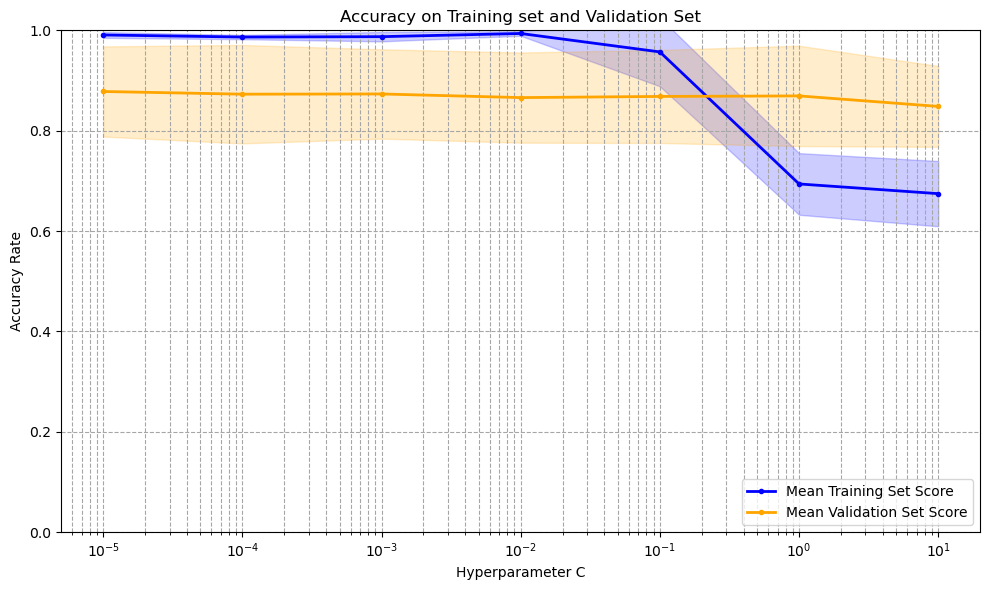

my_classifier__alpha: 1e-05


In [41]:
C_values = gsearch_results_df_2['param_my_classifier__alpha'].values.astype(float)
mean_train_score = gsearch_results_df_2['mean_train_score'].values
std_train_score = gsearch_results_df_2['std_train_score'].values
mean_test_scores = gsearch_results_df_2['mean_test_score'].values
std_test_scores = gsearch_results_df_2['std_test_score'].values

# Plotting
plt.figure(figsize=(10, 6))

# Training and validation mean scores
plt.plot(C_values, mean_train_score, '.-', color='blue', lw=2, label='Mean Training Set Score')
plt.plot(C_values, mean_test_scores, '.-', color='orange', lw=2, label='Mean Validation Set Score')

# Standard deviation range
plt.fill_between(C_values,
                 mean_train_score - std_train_score,
                 mean_train_score + std_train_score,
                 color='blue', alpha=0.2)
plt.fill_between(C_values,
                 mean_test_scores - std_test_scores,
                 mean_test_scores + std_test_scores,
                 color='orange', alpha=0.2)

plt.xscale("log")
plt.title("Accuracy on Training set and Validation Set")
plt.xlabel('Hyperparameter C')
plt.ylabel('Accuracy Rate')
plt.legend(loc='lower right')
plt.ylim([0, 1])  # Assuming accuracy rate, range between 0 and 1
plt.grid(True, which="both", ls="--", c='0.65')
plt.tight_layout()
plt.show()

# Display best hyperparameters
for param_name in sorted(prob2_my_parameter_grid_by_name_embed.keys()):
    print(f"{param_name}: {prob2_grid_searcher_embed.best_params_[param_name]}")


<class 'numpy.ndarray'>
(300, 784)


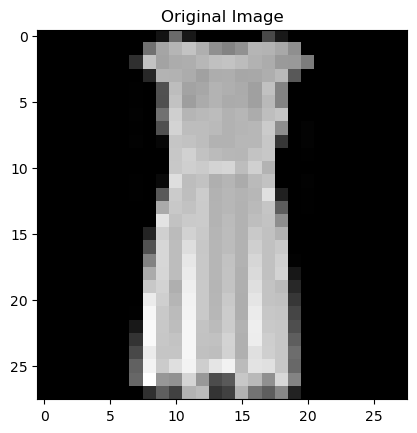

In [171]:
x_vflip = []
size_param = 300
for image_1d in valid_x[:size_param]:
    image_2d = image_1d.reshape(28, 28)
    image_flip_2d = np.fliplr(image_2d)
    image_flip_1d = image_flip_2d.flatten()
    x_vflip.append(image_flip_1d)
x_vflip_arr = np.array(x_vflip).reshape(size_param,784)
#print(len(x_vflip))
print(type(x_vflip_arr))
print(x_vflip_arr.shape)
#print(x_vflip_arr[0])

plt.imshow(x_vflip_arr[0].reshape((28,28)), cmap='gray')
plt.title('Original Image')
plt.show()

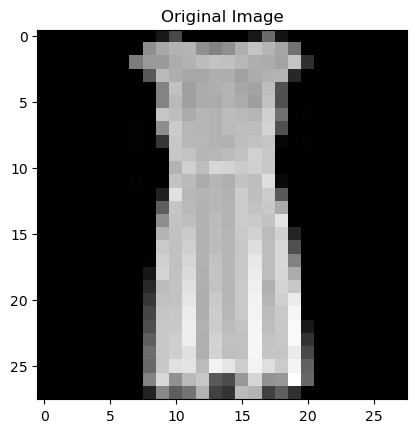

In [172]:
plt.imshow(valid_x[0].reshape((28,28)), cmap='gray')
plt.title('Original Image')
plt.show()

In [49]:
from scipy.ndimage import rotate

x_rotate_n10 = []
x_rotate_p10 = []

for image_1d in valid_x[:size_param]:
    image_2d = image_1d.reshape(28, 28)
    rotated_image_n10 = rotate(image_2d, -10, reshape=False)
    rotated_image_p10 = rotate(image_2d, 10, reshape=False)
    x_rotate_n10.append(rotated_image_n10)
    x_rotate_p10.append(rotated_image_p10)


x_rotate_n10_arr = np.array(x_rotate_n10).reshape(size_param,784)
x_rotate_p10_arr = np.array(x_rotate_p10).reshape(size_param,784)   
print(x_rotate_n10_arr.shape)
print(x_rotate_p10_arr.shape)

(300, 784)
(300, 784)


In [175]:
prob2_x_huge = np.concatenate((prob2_x_comb, x_vflip_arr, x_rotate_n10_arr, x_rotate_p10_arr), axis=0)
prob2_y_huge = np.hstack((prob2_y_comb, y_valid[:size_param], y_valid[:size_param], y_valid[:size_param]))
prob2_y_huge=prob2_y_huge.astype('int')

print(prob2_x_huge.shape)
print(prob2_y_huge.shape)

(3602, 784)
(3602,)


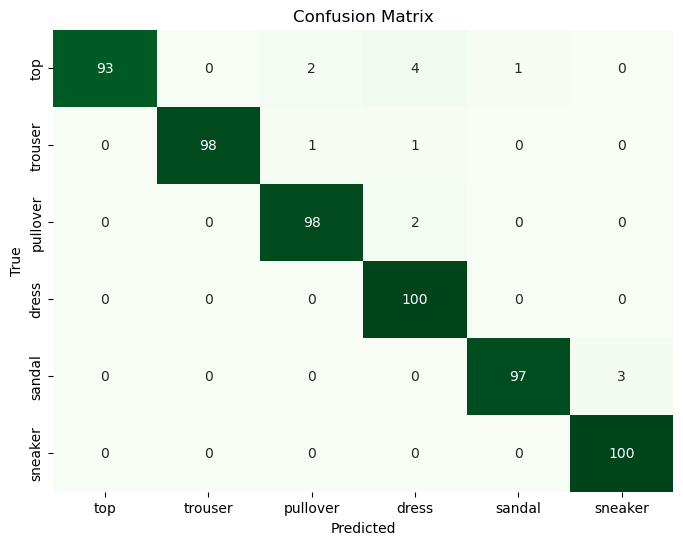

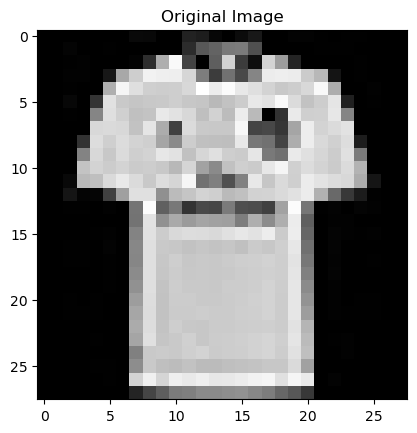

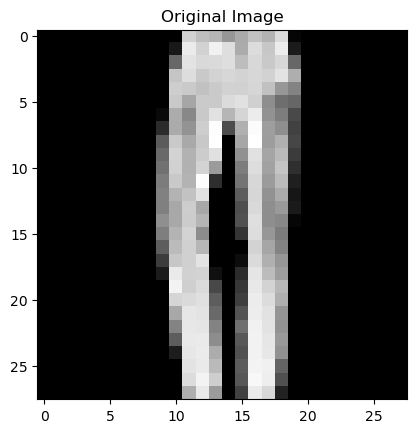

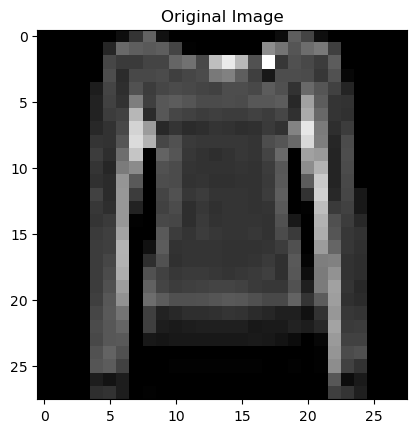

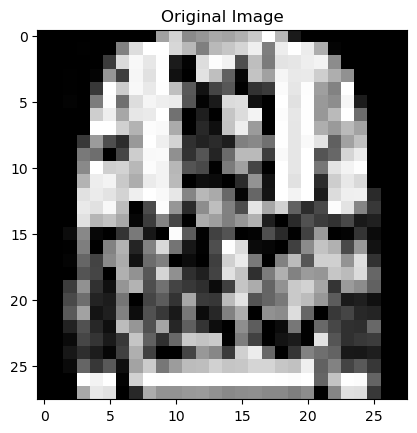

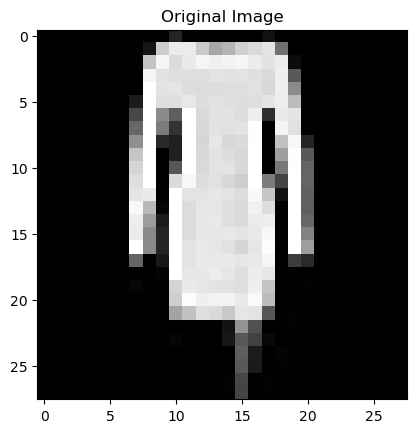

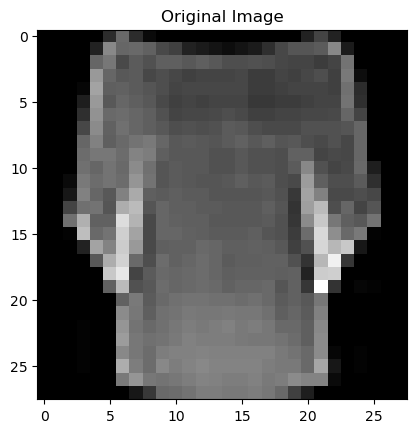

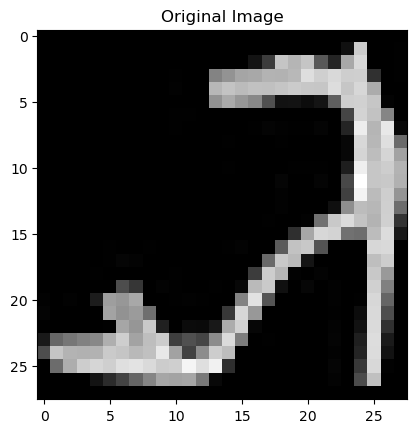

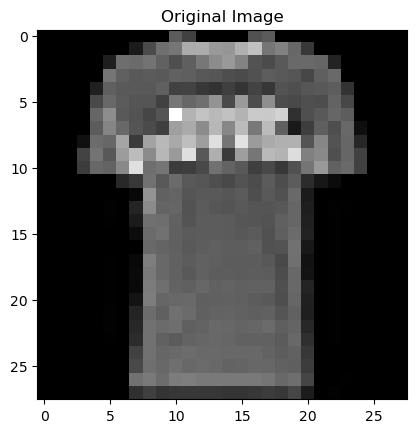

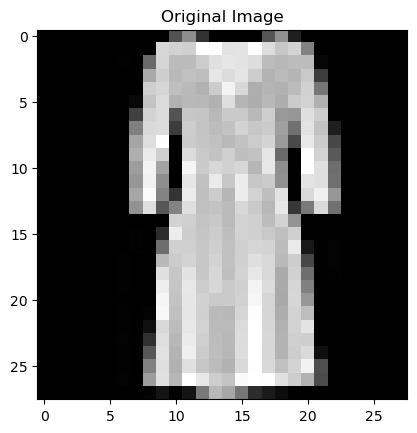

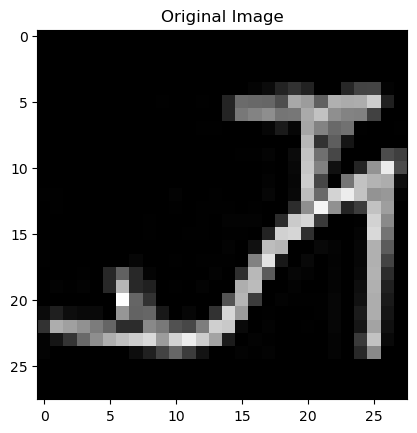

In [155]:
for i in test_x[:10]:
    plt.imshow(i.reshape((28,28)), cmap='gray')
    plt.title('Original Image')
    plt.show()

In [167]:
import time
start = time.time()

prob2_new_mlp = sklearn.pipeline.Pipeline([
    ('max_abs_scaler', preprocessing.MinMaxScaler()),
    ('my_classifier', sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(256,),
                                                           activation='relu',
                                                           solver='adam',
                                                           learning_rate_init=0.01,
                                                           random_state=5,
                                                           max_iter = 300,
                                                           alpha=0.00001,
                                                           early_stopping=True
                                                          )
    )
])

prob2_my_parameter_grid_by_name_embed = dict()
#prob2_my_parameter_grid_by_name_embed['my_classifier__learning_rate_init'] = np.logspace(-5, 1, 7)
prob2_my_parameter_grid_by_name_embed['my_classifier__alpha'] = np.logspace(-5, 1, 7)
#prob2_my_parameter_grid_by_name_embed['my_classifier__hidden_layer_sizes'] = [(256,), (224,),(448,)]
#prob2_my_parameter_grid_by_name_embed['my_classifier__max_iter'] = [100,200,250,300]
#['my_classifier__solver'] = ['sgd', 'adam','lbfgs']
#prob2_my_parameter_grid_by_name_embed['my_classifier__activation'] = ['relu', 'logistic','identity']
#prob2_my_parameter_grid_by_name_embed['my_classifier__random_state'] = np.random.randint(low=0, high=50, size=(50,))

prob2_grid_searcher_embed = sklearn.model_selection.GridSearchCV(
    prob2_new_mlp,
    prob2_my_parameter_grid_by_name_embed,
    scoring='balanced_accuracy',
    cv=5,
    return_train_score=True,
    #n_jobs=-1,
    verbose=3,
    refit=False
)

prob2_grid_searcher_embed.fit(prob2_x_huge, prob2_y_huge)
#prob2_grid_searcher_embed.fit(x_comb, y_comb)


gsearch_results_df_2 = pd.DataFrame(prob2_grid_searcher_embed.cv_results_).copy()
param_keys = ['param_my_classifier__alpha']
print(gsearch_results_df_2.round(3))
# Rearrange row order so it is easy to skim
gsearch_results_df_2.sort_values(param_keys, inplace=True)
var_2 = gsearch_results_df_2[param_keys + ['mean_test_score', 'rank_test_score']]
print(var_2)

for param_name in sorted(prob2_my_parameter_grid_by_name_embed.keys()):
    print("%s: %r" % (param_name, prob2_grid_searcher_embed.best_params_[param_name]))

end = time.time()
print(end - start)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END my_classifier__alpha=1e-05;, score=(train=0.984, test=0.932) total time=   7.1s
[CV 2/5] END my_classifier__alpha=1e-05;, score=(train=0.965, test=0.932) total time=   5.0s
[CV 3/5] END my_classifier__alpha=1e-05;, score=(train=0.989, test=0.943) total time=   8.2s
[CV 4/5] END my_classifier__alpha=1e-05;, score=(train=0.976, test=0.874) total time=   5.7s
[CV 5/5] END my_classifier__alpha=1e-05;, score=(train=0.952, test=0.836) total time=   3.2s
[CV 1/5] END my_classifier__alpha=0.0001;, score=(train=0.975, test=0.935) total time=   4.6s
[CV 2/5] END my_classifier__alpha=0.0001;, score=(train=0.962, test=0.933) total time=   5.3s
[CV 3/5] END my_classifier__alpha=0.0001;, score=(train=0.980, test=0.939) total time=   6.3s
[CV 4/5] END my_classifier__alpha=0.0001;, score=(train=0.986, test=0.911) total time=   7.7s
[CV 5/5] END my_classifier__alpha=0.0001;, score=(train=0.952, test=0.836) total time=   3.3s
[CV 1

In [178]:
prob2_new_best_mlp = sklearn.pipeline.Pipeline([
    ('max_abs_scaler', preprocessing.MinMaxScaler()),
    ('my_classifier', sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(256,),
                                                           activation='relu',
                                                           solver='adam',
                                                           random_state=5,
                                                           max_iter = 300,
                                                           learning_rate_init=0.001,
                                                           alpha=0.001,
                                                           early_stopping=True,
                                                           warm_start=True
                                                           #learning_rate = 'adaptive'
                                                          )
    )
])

#new_best_mlp.fit(train_x, y_train)

prob2_new_best_mlp.fit(prob2_x_huge, prob2_y_huge)
prob2_best_y_hat_valid = prob2_new_best_mlp.predict(valid_x)
prob2_best_y_hat_test = prob2_new_best_mlp.predict(test_x)

save_text(prob2_best_y_hat_valid, 'yhat_valid.txt')
save_text(prob2_best_y_hat_test, 'yhat_test.txt')
pretty_print('y_valid.csv','yhat_valid.txt')

Balanced Accuracy: 0.977



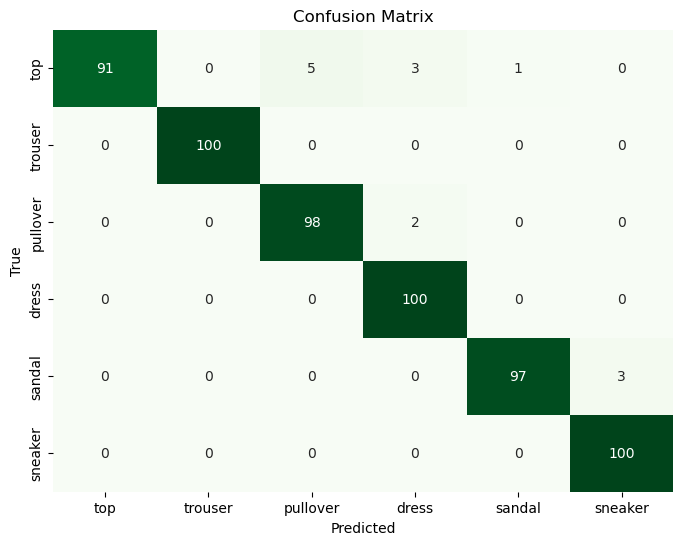

In [179]:
conf_matrix = confusion_matrix(list(y_valid), list(prob2_best_y_hat_valid))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['top', 'trouser', 'pullover', 'dress', 'sandal', 'sneaker'],
            yticklabels=['top', 'trouser', 'pullover', 'dress', 'sandal', 'sneaker'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Ju-Hung's Approch

In [8]:
# x_comb, y_comb are the duplicated training datasets
# take partial of valid_x into prob2_x_combo and prob2_y_combo

print(valid_x.shape, y_valid.shape)
print()

(600, 784) (600,)



In [30]:
# change size_param for partial validation dataset
from scipy.ndimage import rotate
size_param = 300

# selected_top = []
# selected_trouser = []

# # Iterate over the data
# for n, values in enumerate(valid_y_df['class_uid']):
#     if values == 0:
#         selected_top.append(n)
#     elif values == 1:
#         selected_trouser.append(n)
        
# selected_top = np.random.choice(selected_top, size=20, replace=False)
# selected_trouser = np.random.choice(selected_trouser, size=20, replace=False)

# prob2_x_top = valid_x[selected_top]
# prob2_x_trouser = valid_x[selected_trouser]
# prob2_x_tt = np.concatenate((prob2_x_top, prob2_x_trouser), axis=0)
# prob2_y_tt = np.concatenate((np.zeros(len(prob2_x_top)), np.ones(len(prob2_x_top))), axis=0)

prob2_x_comb = np.concatenate((train_x, valid_x[:size_param]))
prob2_y_comb = np.hstack((y_train, y_valid[:size_param]))

prob2_x_vflip = []
for image_1d in valid_x[:size_param]:
    image_2d = image_1d.reshape(28, 28)
    image_flip_2d = np.fliplr(image_2d)
    image_flip_1d = image_flip_2d.flatten()
    prob2_x_vflip.append(image_flip_1d)
prob2_x_vflip_arr = np.array(prob2_x_vflip).reshape(size_param,784)


prob2_x_rotate_n10 = []
prob2_x_rotate_p10 = []

for image_1d in valid_x[:size_param]:
    image_2d = image_1d.reshape(28, 28)
    rotated_image_n10 = rotate(image_2d, -10, reshape=False)
    rotated_image_p10 = rotate(image_2d, 10, reshape=False)
    prob2_x_rotate_n10.append(rotated_image_n10)
    prob2_x_rotate_p10.append(rotated_image_p10)

prob2_x_rotate_n10_arr = np.array(prob2_x_rotate_n10).reshape(size_param,784)
prob2_x_rotate_p10_arr = np.array(prob2_x_rotate_p10).reshape(size_param,784)  

prob2_x_combo = np.concatenate((prob2_x_comb, prob2_x_vflip_arr, prob2_x_rotate_n10_arr, prob2_x_rotate_p10_arr), axis=0)
prob2_y_combo = np.hstack((prob2_y_comb, y_valid[:size_param], y_valid[:size_param], y_valid[:size_param]))
prob2_y_combo = prob2_y_combo.astype('int')


new_x_valid = valid_x[size_param:]
save_text(y_valid[size_param:], "data_fashion/whatever.txt")

print(prob2_y_combo.shape, prob2_x_combo.shape)

(3302,) (3302, 784)


In [29]:
import time
start = time.time()

prob2_new_mlp = sklearn.pipeline.Pipeline([
    ('max_abs_scaler', preprocessing.MinMaxScaler()),
    ('my_classifier', sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(256,),
                                                           activation='relu',
                                                           solver='adam',
                                                           learning_rate_init=0.01,
                                                           random_state=5,
                                                           max_iter = 300,
                                                           alpha=0.00001,
                                                           early_stopping=True
                                                          )
    )
])

prob2_my_parameter_grid_by_name_embed = dict()
#prob2_my_parameter_grid_by_name_embed['my_classifier__learning_rate_init'] = np.logspace(-5, 1, 7)
prob2_my_parameter_grid_by_name_embed['my_classifier__alpha'] = np.logspace(-5, 1, 7)
#prob2_my_parameter_grid_by_name_embed['my_classifier__hidden_layer_sizes'] = [(256,), (224,),(448,)]
#prob2_my_parameter_grid_by_name_embed['my_classifier__max_iter'] = [100,200,250,300]
#['my_classifier__solver'] = ['sgd', 'adam','lbfgs']
#prob2_my_parameter_grid_by_name_embed['my_classifier__activation'] = ['relu', 'logistic','identity']
#prob2_my_parameter_grid_by_name_embed['my_classifier__random_state'] = np.random.randint(low=0, high=50, size=(50,))

prob2_grid_searcher_embed = sklearn.model_selection.GridSearchCV(
    prob2_new_mlp,
    prob2_my_parameter_grid_by_name_embed,
    scoring='balanced_accuracy',
    cv=5,
    return_train_score=True,
    #n_jobs=-1,
    verbose=3,
    refit=False
)

prob2_grid_searcher_embed.fit(prob2_x_combo, prob2_y_combo)
#prob2_grid_searcher_embed.fit(x_comb, y_comb)


gsearch_results_df_2 = pd.DataFrame(prob2_grid_searcher_embed.cv_results_).copy()
param_keys = ['param_my_classifier__alpha']
print(gsearch_results_df_2.round(3))
# Rearrange row order so it is easy to skim
gsearch_results_df_2.sort_values(param_keys, inplace=True)
var_2 = gsearch_results_df_2[param_keys + ['mean_test_score', 'rank_test_score']]
print(var_2)

for param_name in sorted(prob2_my_parameter_grid_by_name_embed.keys()):
    print("%s: %r" % (param_name, prob2_grid_searcher_embed.best_params_[param_name]))

end = time.time()
print(end - start)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END my_classifier__alpha=1e-05;, score=(train=0.995, test=0.929) total time=   4.2s
[CV 2/5] END my_classifier__alpha=1e-05;, score=(train=0.980, test=0.928) total time=   3.4s
[CV 3/5] END my_classifier__alpha=1e-05;, score=(train=0.939, test=0.920) total time=   1.7s
[CV 4/5] END my_classifier__alpha=1e-05;, score=(train=0.980, test=0.920) total time=   2.9s
[CV 5/5] END my_classifier__alpha=1e-05;, score=(train=0.970, test=0.784) total time=   2.1s
[CV 1/5] END my_classifier__alpha=0.0001;, score=(train=0.995, test=0.939) total time=   3.9s
[CV 2/5] END my_classifier__alpha=0.0001;, score=(train=0.968, test=0.940) total time=   2.7s
[CV 3/5] END my_classifier__alpha=0.0001;, score=(train=0.940, test=0.933) total time=   1.6s
[CV 4/5] END my_classifier__alpha=0.0001;, score=(train=0.962, test=0.919) total time=   2.2s
[CV 5/5] END my_classifier__alpha=0.0001;, score=(train=0.970, test=0.784) total time=   2.0s
[CV 1

In [39]:
alpha_list = np.logspace(-5, 1, 7)

for alpha in alpha_list:
    print(alpha)
    mlp = sklearn.pipeline.Pipeline([
        ('max_abs_scaler', preprocessing.MinMaxScaler()),
        ('my_classifier', sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(256,),
                                                               activation='relu',
                                                               solver='adam',
                                                               learning_rate_init=0.01,
                                                               random_state=5,
                                                               max_iter = 300,
                                                               alpha=alpha,
                                                               early_stopping=True
                                                              )
        )
    ])
    mlp.fit(prob2_x_combo, prob2_y_combo)
    prob2_best_y_hat_valid = mlp.predict(new_x_valid)

    save_text(prob2_best_y_hat_valid, 'yhat_valid.txt')
    pretty_print('whatever.txt','yhat_valid.txt')



1e-05
Balanced Accuracy: 0.926

0.0001
Balanced Accuracy: 0.924

0.001
Balanced Accuracy: 0.931

0.01
Balanced Accuracy: 0.911

0.1
Balanced Accuracy: 0.928

1.0
Balanced Accuracy: 0.924

10.0
Balanced Accuracy: 0.893



# Tried with 20 examples of top and trouser  from validation

In [16]:

prob2_new_best_mlp = sklearn.pipeline.Pipeline([
    ('max_abs_scaler', preprocessing.MinMaxScaler()),
    ('my_classifier', sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(256,),
                                                           activation='relu',
                                                           solver='adam',
                                                           random_state=5,
                                                           max_iter = 300,
                                                           learning_rate_init=0.001,
                                                           alpha=0.001,
                                                           early_stopping=True,
                                                           warm_start=True
                                                           #learning_rate = 'adaptive'
                                                          )
    )
])

#new_best_mlp.fit(train_x, y_train)

prob2_new_best_mlp.fit(prob2_x_combo, prob2_y_combo)
prob2_best_y_hat_valid = prob2_new_best_mlp.predict(valid_x)
prob2_best_y_hat_test = prob2_new_best_mlp.predict(test_x)

save_text(prob2_best_y_hat_valid, 'yhat_valid.txt')
save_text(prob2_best_y_hat_test, 'yhat_test.txt')

In [104]:
prob2_x_vflip = []

for image_1d in prob2_x_combo:
    image_2d = image_1d.reshape(28, 28)
    image_flip_2d = np.fliplr(image_2d)
    image_flip_1d = image_flip_2d.flatten()
    prob2_x_vflip.append(image_flip_1d)
prob2_x_vflip_arr = np.array(prob2_x_vflip).reshape(len(prob2_y_combo),784)
prob2_y_combo = prob2_y_combo.astype('int')


prob2_x_rotate_n10 = []
prob2_x_rotate_p10 = []

for image_1d in prob2_x_combo:
    image_2d = image_1d.reshape(28, 28)
    rotated_image_n10 = rotate(image_2d, -10, reshape=False)
    rotated_image_p10 = rotate(image_2d, 10, reshape=False)
    prob2_x_rotate_n10.append(rotated_image_n10)
    prob2_x_rotate_p10.append(rotated_image_p10)


prob2_x_rotate_n10_arr = np.array(prob2_x_rotate_n10).reshape(len(prob2_y_combo),784)
prob2_x_rotate_p10_arr = np.array(prob2_x_rotate_p10).reshape(len(prob2_y_combo),784)  


prob2_x_combo = np.concatenate((prob2_x_combo, prob2_x_vflip_arr, prob2_x_rotate_n10_arr, prob2_x_rotate_p10_arr), axis=0)
prob2_y_combo = np.hstack((prob2_y_combo, prob2_y_combo, prob2_y_combo, prob2_y_combo))

print(prob2_y_combo.shape, prob2_x_combo.shape)

AttributeError: 'list' object has no attribute 'astype'

In [83]:
prob2_new_best_mlp = sklearn.pipeline.Pipeline([
    ('max_abs_scaler', preprocessing.MinMaxScaler()),
    ('my_classifier', sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(256,),
                                                           activation='relu',
                                                           solver='adam',
                                                           random_state=5,
                                                           max_iter = 300,
                                                           learning_rate_init=0.001,
                                                           alpha=0.001,
                                                           early_stopping=True,
                                                           warm_start=True
                                                           #learning_rate = 'adaptive'
                                                          )
    )
])

#new_best_mlp.fit(train_x, y_train)

prob2_new_best_mlp.fit(prob2_x_combo, prob2_y_combo)
prob2_best_y_hat_valid = prob2_new_best_mlp.predict(new_x_valid)
prob2_best_y_hat_test = prob2_new_best_mlp.predict(test_x)

save_text(prob2_best_y_hat_valid, 'yhat_valid.txt')
save_text(prob2_best_y_hat_test, 'yhat_test.txt')
pretty_print('whatever.txt','yhat_valid.txt')


Balanced Accuracy: 0.922

Accuracy: 0.917
